### Advanced Time Series

이번 시간에서는 Financial Analysis의 최신 방법론과 이슈들에 대해 살펴보기로 한다

#### 1. Fractionally Differentiated Series

대부분의 금융 시계열 분석은 두가지 상황에서 딜레마에 빠진다
1. Box-Jenkins : log difference 데이터는 정상성을 가지지만, market memory를 가지지 않는다
2. Engle-Granger : log price 계열은 market memory를 가진다. 하지만 비정상성을 얻게 된다. Cointegration은 비정상성 시계열에서 회귀모형을 작동 가능하게 하지만 매우 제한적인 상황에서 발견되며, Cointegration의 안정성도 신뢰가 좋다고는 볼 수 없다

Fractional Difference는 ADF 검정 결과를 지키는 최소한의 차분계수($d$)통해 market memory와 stationarity를 모두 포함하는 변환을 해주는 통계학 방법이다

**1.1 Methodology**

실수값인 feature $\{X_t\}$에 적용한 backshift 연산자 $B$를 가정해 보자. 여기서 $k \geq 0$인 모든 정수에 대해 $B^kX_t = X_{t-k}$이다. 양의 정수 $n$에 $(x+y)^n = \sum_{k=0}^n {n \choose k} x^k y^{n-k} = \sum_{k=0}^n {n \choose k}x^{n-k}k^k$라는 것에 주목하자. 실수 $d$에서 $(1+x)^d = \sum_{k=0}^\infty {d \choose k} x^k$ 즉, 이항 계열이다. Fractionally differentiated model에서 지수 $d$는 실수값이 가능하고, 다음 형식의 이항 계열 확장을 따른다

$$\begin{matrix}
(1-B)^d = \sum_{k=0}^\infty {d \choose k}(-B)^k &=& \sum_{k=0}^\infty \frac{\prod_{i=0}^{k-1}(d-i)}{k!} \\
       &=& \sum_{k=0}^\infty (-B)^k \prod_{i=0}^{k-1}\frac{d-i}{k-i} \\
       &=& 1 - dB + \frac{d(d-1)}{2!}B^2 - \frac{d(d-1)(d-2)}{3!}B^3 + \cdots
\end{matrix}$$

**1.2 Long Memory**

양의 실수 $d$가 기억을 유지하는 법을 알아보도록 하자. 아래의 산술 계열은 내적으로 이뤄져 있다

$$\tilde X_t = \sum_{k=0}^\infty \omega_k X_{t-k}$$

여기서 가중값 $\omega$는

$$\omega = \Big\{
1, -d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \cdots, (-1)^k \prod_{i=0}^{k-1} \frac{d-i}{k!}, \cdots
\Big\}$$

그리고 값 $X$는

$$X = \{X_t, X_{t-1}, X_{t-2}, X_{t-3}, \dots, X_{t-k}, \dots\}$$

이다.

$d$가 양의 정수일 때 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>d$이고, 이 지점을 넘어선 market memory는 소멸된다. 예를들어, $d=1$일 경우 수익률을 계산하기 위해 사용하는 차분계수이다. 여기서 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>1$이고 $\omega = \{1,-1,0,0,\cdots \}$이다

가중값 $\omega$의 sequence를 살펴보면 $\omega_0 = 1$이고, $k = 0, \dots, \infty$에 대해서 가중값은 반복적으로 다음과 같이 생성된다.

$$\omega_k = -\omega_{k-1}\frac{d-k+1}{k}$$

**1.3 Stationarity with Maximum Memory Preservation**

Time series $\{X_t\}_{t=1, \dots, T}$를 고려해 보자. Fixing-width window fractional difference 방법을 이 계열에 적용하면 Fractional differentiated Series $\{\tilde X_t\}_{t=l^*, \dots, T}$이 정상성을 가지도록 하는 최소의 차분계수 $d^*$를 구할 수 있다. 이 계수는 정상성을 얻기 위해 없애야 하는 기억의 양을 정량화 한다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 이미 stationary하다면 $d^*=0$이다

$\{\tilde X_t\}_{t=l^*, \dots, T}$가 unit root을 가지고 있다면 $d^* <1$이다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 폭발적 행태를 보인다면 $d^* >1$이다. 이 중 $0<d^* <1$인 경우는 원시계열이 약간의 비정상성을 가지는 경우로, 이 경우 정상성을 위해 차분이 필요하지만, 1차 차분을 하게 되면 원시계열에 담겨 있는 market memory와 유의미한 신호를 제거하게 된다

#### example 1

yfinance library를 통해 2015년 1월 1일부터 2023년 7월 31일까지의 Apple의 주가를 import하라. 작성된 함수를 이용하여 아래의 물음에 답하라

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

start_date = '2015-01-01'
end_date = '2023-08-01'

apple = yf.download('AAPL', start = start_date, end = end_date).iloc[:,[0,1,2,3,5]]
apple

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000
...,...,...,...,...,...
2023-07-25,193.330002,194.440002,192.919998,193.619995,37283200
2023-07-26,193.669998,195.639999,193.320007,194.500000,47471900
2023-07-27,196.020004,197.199997,192.550003,193.220001,47460200


**1.1 Long Memory**

닫힌 구간 [0,2]까지 0.1구간별로 차분계수 $d$를 검정하여 Augmented Dickey Fuller test 값이 유의수준 5%(신뢰구간 95%)를 통과하는 최소의 차분계수를 구하여라. $d$의 값이 0에 가까울수록 어떤 insight를 얻을 수 있는가?

In [2]:
import AdvancedTimeSeries as ats

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(apple).dropna()
        df2 = ats.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/

d: 0.1, error: division by zero
d: 0.2, error: Invalid input, x is constant
d: 0.30000000000000004, error: Invalid input, x is constant
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.075185,9.518548e-01,1.0,2155.0,-2.862882,1.000000
0.5,-1.260632,6.469853e-01,1.0,5.0,-3.929280,0.887011
0.6,-2.154825,2.230478e-01,1.0,13.0,-3.127149,0.556117
0.7,-3.912521,1.944609e-03,1.0,37.0,-2.943539,0.181059
0.8,-8.264837,4.970473e-13,1.0,107.0,-2.888955,0.146515
0.9,-13.747610,1.065264e-25,1.0,377.0,-2.869237,0.187848
1.0,-34.497045,0.000000e+00,1.0,2154.0,-2.862883,0.023718
1.1,-26.727279,0.000000e+00,1.0,1052.0,-2.864291,-0.003630
1.2,-29.551898,0.000000e+00,1.0,1114.0,-2.864138,0.002519
1.3,-34.233119,0.000000e+00,1.0,1318.0,-2.863735,0.006049


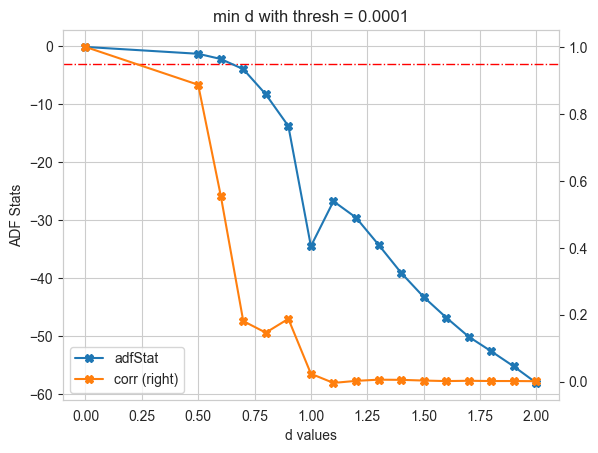

In [3]:
f,ax = plt.subplots()
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats');
display(out)

유의수준 5%이내인 최소의 $d$값은 0.6이다. $d$의 값이 0에 가까울수록 시계열이 최소의 차분만으로 정상성을 가진다는 뜻이므로, 원시계열이 효율적이라는 것을 유추해낼 수 있다

**1.2 Fixing window Fractional Differentiated Series**

함수 `fracDiff_FFD`는 윈도우를 고정하고 실수 차원의 차분 시계열을 추정하는 함수이다. 함수에 대해 적절한 방법으로 plotting하고 histogram을 확인하라

Text(0.5, 1.0, 'Fixing Window Fractional Differentiated Series')

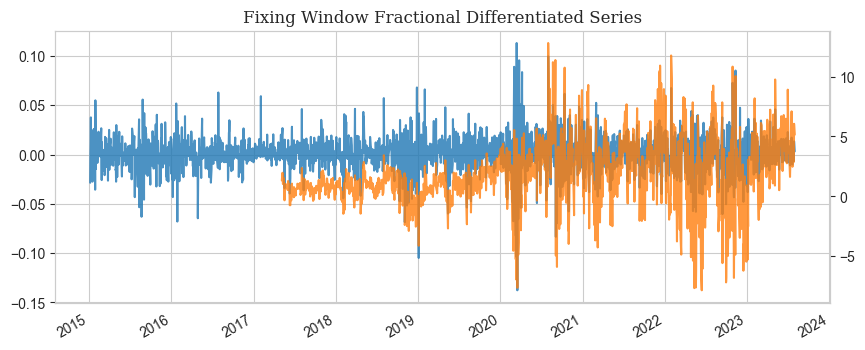

In [4]:
plt.figure(figsize = (10,4))
plt.plot(np.log(apple.Close / apple.Close.shift(1)).dropna(), alpha = 0.8)
ats.fracDiff_FFD(apple, 0.6).Close.plot(secondary_y = True, alpha = 0.8)
plt.title('Fixing Window Fractional Differentiated Series', fontfamily = 'Serif', fontsize = 12)

<Axes: xlabel='Close', ylabel='Count'>

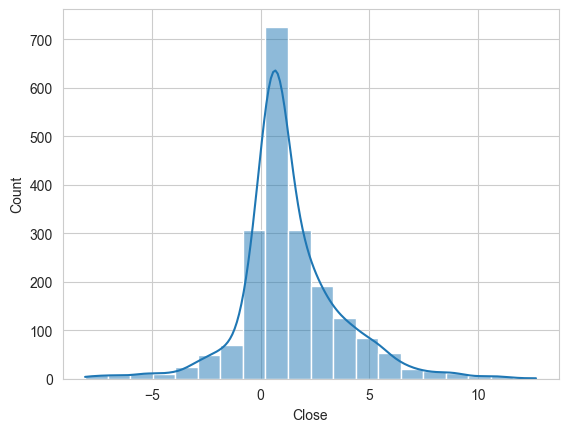

In [5]:
import seaborn as sns
sns.histplot(ats.fracDiff(apple, 0.6).Close, kde = True, bins = 20)

fixing window의 경우 양의 왜도와 높은 첨도를 가진다

**1.3 Expanding window Fractional Differentiated Series**

함수 `fracDiff`는 윈도우를 확장하며 실수 차원의 차분 시계열을 추정하는 함수이다. 함수에 대해 적절한 방법으로 plotting하고 histogram을 확인하라

Text(0.5, 1.0, 'Expanding Window Fractional Differentiated Series')

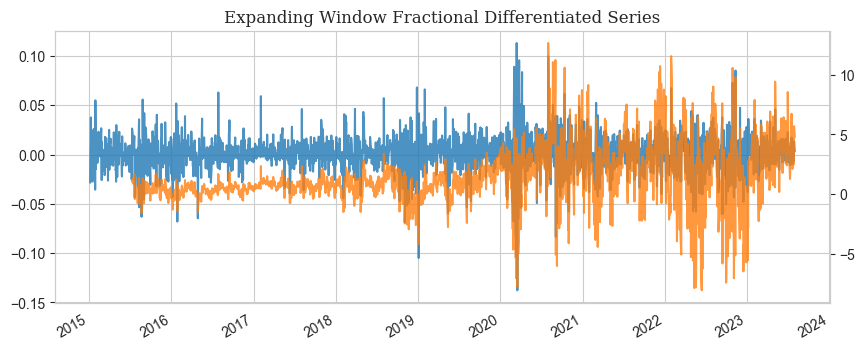

In [6]:
plt.figure(figsize = (10,4))
plt.plot(np.log(apple.Close / apple.Close.shift(1)).dropna(), alpha = 0.8)
ats.fracDiff(apple, 0.6).Close.plot(secondary_y = True, alpha = 0.8)
plt.title('Expanding Window Fractional Differentiated Series', fontfamily = 'Serif', fontsize = 12)

<Axes: xlabel='Close', ylabel='Count'>

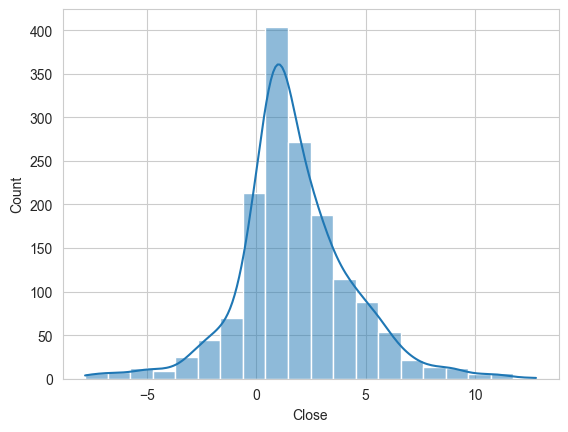

In [7]:
sns.histplot(ats.fracDiff_FFD(apple, 0.6).Close, kde = True, bins = 20)

fixing window 방식에 비해 왜도가 낮고 첨도 또한 낮아진 것을 볼 수 있다. 다만, 확장 윈도우 방식의 경우 초기 추정값의 신뢰성이 낮아질 수 있다

**1.4 Supremum Augmented Dickey-Fuller Test**

표준 단위근과 공적분 검정은 stationary process와 주기적 붕괴 거품 모형을 효과적으로 구분하지 못하기 떄문에 거품을 탐지하는 도구로서 적절하지 못하다. 데이터에서 주기적으로 붕괴하는 패턴들은 잠재적으로 복발하는 프로세스보다는 단위근이나 정상성이 있는 AR process로부터 생성된 데이터처럼 보인다.(Phillips, Wu and Yu, 2011)
이들은 이 결함을 해결하고자 다음 식의 회귀식을 적합화할것을 제안하였다

$$\Delta y_t = \alpha + \beta y_{t-1} + \sum_{l=1}^L \gamma_l \Delta y_{t-l} + \epsilon_t, ~~~~~ \epsilon_t \sim NID(0, \sigma_y^2)$$

여기서 아래의 귀무가설을 검정한다

$$H_0 : \beta \leq 0, ~~~~~ H_1 : \beta > 0$$

그리고 아래와 같은 검정을 제안하였다. $SDAF$는 앞의 회귀식을 각 마지막 시점 $T$에서 역방향 확장이 시작되는 시점들로 fitting한 후 다음을 계산한다

$$\mathrm{SADF}_t = \sup_{t_0 \in [1, t-\tau]} \{\mathrm{ADF}_{t_0, t}\} = \sup_{t_0 \in [1, t-\tau]} \Big\{ \frac{\hat \beta_{t_0, t}}{\hat \sigma_{\beta_{t_0},t}}\Big\}$$

여기서 $\hat \beta_{t_0, t}$는 $t_0$에서 시작해 $t$에서 끝나는 샘플에서 계산하고, $\tau$는 분석에 사용되는 최소 표본 길이, $t_0$는 역방향 확장 윈도우의 왼쪽 경계이고 $t = \tau, \dots, T$이다

In [8]:
sadf = ats.get_bSADF_test_statistics(np.log(apple.Close), minSL = 100, constant = 'ct', lags = 1)

Text(0.5, 1.0, 'Supremum ADF test (Apple)')

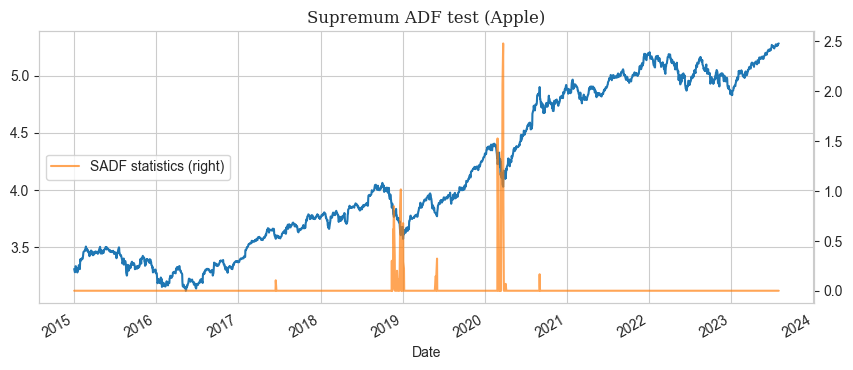

In [14]:
plt.figure(figsize = (10, 4))
plt.plot(np.log(apple.Close))
sadf.plot(secondary_y = True, alpha = 0.7, label = 'SADF statistics')
plt.legend(loc = 'center left')
plt.title('Supremum ADF test (Apple)', fontfamily = 'Serif', fontsize = 12)

#### 2. Market Entropy Features


#### 3.